# AlexNet实现跌倒检测

In [1]:
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms,datasets
import shutil
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time 

## 数据导入

In [2]:
transform=transforms.Compose([transforms.Resize(256),transforms.CenterCrop(227),transforms.ToTensor(),transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  ])

In [3]:
train_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/URFD_images/data/train',transform=transform)
val_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/URFD_images/data/val',transform=transform)
test_dataset=datasets.ImageFolder('C:/Users/Desktop/20230511_code/URFD_images/data/test',transform=transform)

In [4]:
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## 定义模型

In [5]:
class MyConvModule(torch.nn.Module):
    def __init__(self):
        super(MyConvModule,self).__init__()
        self.layer1=torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.MaxPool2d(3, 2),
                                       torch.nn.LocalResponseNorm(2))
        self.layer2=torch.nn.Sequential(torch.nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,groups=2,padding=2),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.MaxPool2d(3, 2),
                                       torch.nn.LocalResponseNorm(2))
        self.layer3=torch.nn.Sequential(torch.nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
                                       torch.nn.ReLU(inplace=True))
        self.layer4=torch.nn.Sequential(torch.nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
                                       torch.nn.ReLU(inplace=True))
        self.layer5=torch.nn.Sequential(torch.nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.MaxPool2d(3, 2))
        self.layer6=torch.nn.Sequential(torch.nn.Linear(in_features=6*6*256, out_features=4096),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout())
        self.layer7=torch.nn.Sequential(torch.nn.Linear(in_features=4096, out_features=4096),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout())
        self.layer8=torch.nn.Sequential(torch.nn.Linear(in_features=4096, out_features=2))
        
    def forward(self,X):
        X=self.layer1(X)
        X=self.layer2(X)
        X=self.layer3(X)
        X=self.layer4(X)
        X=self.layer5(X)
        X=X.view(-1,6*6*256)
        X=self.layer6(X)
        X=self.layer7(X)
        X=self.layer8(X)
        return X

## 定义训练模型函数

In [6]:
def train(net,data_loader):
    net.train()
    train_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        optimizer.zero_grad()
        output=net(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

## 定义测试模型函数

In [7]:
def test(net,data_loader):
    net.eval()
    test_batch_num=len(data_loader)
    total_loss=0
    correct=0
    sample_num=0
    for batch_idx,(data,target) in enumerate(data_loader):
        output=net(data)
        loss=criterion(output,target)
        total_loss+=loss.item()
        prediction=torch.argmax(output,1)
        correct+=(prediction==target).sum().item()
        sample_num+=len(prediction)
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

## 定义损失函数及优化器

In [8]:
net=MyConvModule()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
criterion=torch.nn.CrossEntropyLoss()

MyConvModule(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=

In [9]:
list(net.parameters())

[Parameter containing:
 tensor([[[[-0.0255,  0.0360, -0.0384,  ...,  0.0071,  0.0032,  0.0137],
           [ 0.0042,  0.0002,  0.0476,  ..., -0.0284,  0.0358, -0.0326],
           [ 0.0411,  0.0475, -0.0273,  ...,  0.0159, -0.0242, -0.0052],
           ...,
           [ 0.0227, -0.0420,  0.0477,  ...,  0.0014, -0.0011, -0.0153],
           [ 0.0052,  0.0505, -0.0046,  ..., -0.0452,  0.0068,  0.0136],
           [-0.0407,  0.0233, -0.0302,  ..., -0.0402, -0.0333,  0.0333]],
 
          [[-0.0227,  0.0386,  0.0006,  ..., -0.0407, -0.0408, -0.0361],
           [ 0.0219, -0.0179,  0.0348,  ..., -0.0140,  0.0458, -0.0214],
           [-0.0011,  0.0505,  0.0287,  ..., -0.0259,  0.0349,  0.0430],
           ...,
           [ 0.0412, -0.0408, -0.0403,  ..., -0.0223, -0.0482, -0.0349],
           [-0.0263,  0.0352,  0.0016,  ..., -0.0347, -0.0163,  0.0359],
           [ 0.0058, -0.0512,  0.0454,  ..., -0.0273, -0.0180,  0.0327]],
 
          [[ 0.0319, -0.0348,  0.0089,  ...,  0.0369, -0.0112, 

## 进行迭代

In [14]:
epoch=10
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
test_loss_list=[]
test_acc_list=[]
since=time.time()
for epoch in range(epoch):
    train_loss,train_acc=train(net,train_loader)
    val_loss,val_acc=test(net,val_loader)
    test_loss,test_acc=test(net,test_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch} \t train_loss: {train_loss:.4f}\t"
          f" train_acc: {train_acc}\t"
          f" val_loss: {val_loss:.4f}\t val_acc:{val_acc}"
          f" test_loss: {test_loss:.4f}\t test_acc:{test_acc}")
time_elapsed=(time.time()-since)/60

epoch: 0 	 train_loss: 0.3178	 train_acc: 0.7346938775510204	 val_loss: 0.3124	 val_acc:0.8666666666666667 test_loss: 0.2936	 test_acc:0.8372093023255814
epoch: 1 	 train_loss: 0.3124	 train_acc: 0.7959183673469388	 val_loss: 0.2995	 val_acc:0.9555555555555556 test_loss: 0.2809	 test_acc:0.9534883720930233
epoch: 2 	 train_loss: 0.3120	 train_acc: 0.7857142857142857	 val_loss: 0.2760	 val_acc:0.9777777777777777 test_loss: 0.2587	 test_acc:1.0
epoch: 3 	 train_loss: 0.2994	 train_acc: 0.8367346938775511	 val_loss: 0.2418	 val_acc:1.0 test_loss: 0.2262	 test_acc:1.0
epoch: 4 	 train_loss: 0.2864	 train_acc: 0.826530612244898	 val_loss: 0.1955	 val_acc:1.0 test_loss: 0.1821	 test_acc:1.0
epoch: 5 	 train_loss: 0.2801	 train_acc: 0.8469387755102041	 val_loss: 0.1423	 val_acc:1.0 test_loss: 0.1318	 test_acc:1.0
epoch: 6 	 train_loss: 0.3019	 train_acc: 0.8469387755102041	 val_loss: 0.1365	 val_acc:1.0 test_loss: 0.1267	 test_acc:1.0
epoch: 7 	 train_loss: 0.2825	 train_acc: 0.84693877551020

## 计算训练模型时间

In [15]:
time_elapsed

1.7717015186945597

## 绘制loss曲线以及精度曲线

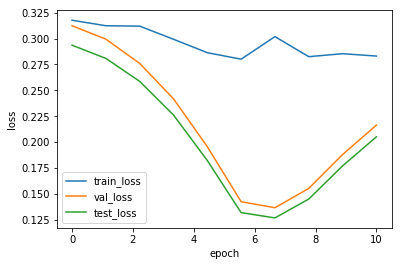

In [16]:
x=np.linspace(0,len(train_loss_list),len(test_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,val_loss_list,label="val_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

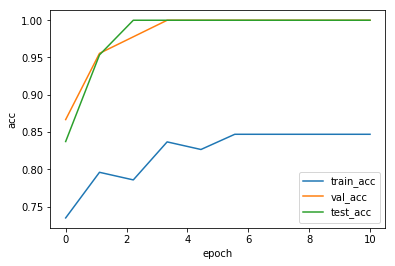

In [17]:
x=np.linspace(0,len(train_acc_list),len(test_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,val_acc_list,label="val_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()